# Códigos

In [ ]:
 !pip install bitstring

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00




### Código Auxiliar

In [ ]:
import pickle
import numpy as np

from itertools import product
from bitstring import BitArray, Bits, BitStream

In [ ]:
class MyImgFormat:
    def __init__(self, mat_rgb_ids, rgb_ids_dict):
        self.im_shape_      = mat_rgb_ids.shape
        self.rgb_ids_dict_  = rgb_ids_dict
        self.num_bits_uint_ = int(np.ceil(np.log2(len(rgb_ids_dict))))

        self._mat2bytes(mat_rgb_ids)

    def _mat2bytes(self, mat):
        self.pixel_bytes_ = BitStream()

        pixel_rgb_ids = mat.reshape(-1)
        for rgb_id in pixel_rgb_ids:
            self.pixel_bytes_.append(Bits(uint=int(rgb_id), length=self.num_bits_uint_))

    def unpack(self):
        # unpack IDs
        cp_bits = self.pixel_bytes_.copy()
        num_ids = cp_bits.len // self.num_bits_uint_

        mat_ids = np.array([
            cp_bits.read('uint:%d' % (self.num_bits_uint_))\
            for i in range(num_ids)\
        ]).reshape(self.im_shape_)

        # unpack RGB
        im_rgb = np.zeros((self.im_shape_[0], self.im_shape_[1], 3), dtype='uint8')
        for i in range(self.im_shape_[0]):
            for j in range(self.im_shape_[1]):
                im_rgb[i, j, :] = self.rgb_ids_dict_[mat_ids[i, j]]

        return im_rgb

In [ ]:
def uniform_quant(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size)
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size)

    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

In [ ]:
def get_bin_size_kb(obj):
    return len(pickle.dumps(obj)) / 1e3

# Exercício 1


a) Ao estudar a função uniform_quant você irá perceber que ela gera os
valores de R, G e B como o valor inicial do intervalo quantizado. Modifique a função para que os valores de RGB sejam o meio
do intervalo quantizado.


In [ ]:
#função alterada

def uniform_quant_meio(im, n_colors):
    # numero de cores e espaco entre as cores (lagura do bin)
    n_vals_ch  = int(np.cbrt(n_colors))
    bin_size   = 256 // n_vals_ch

    # possiveis valores por canal e por pixel (combinacao dos 3 canais)
    ch_vals    = np.uint8((np.arange(n_vals_ch)) * bin_size + bin_size//2) #incrementando valores pela metade do intervalo
    pixel_vals = list(product(ch_vals, ch_vals, ch_vals))

    im_qt_rgb  = im // bin_size
    im_qt_rgb[im_qt_rgb >= n_vals_ch] = n_vals_ch - 1
    im_qt_rgb  = np.uint8((im_qt_rgb) * bin_size + bin_size//2) #incrementando valores pela metade do intervalo

    # criar os dicionarios ID -> pixel e pixel -> ID
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}
    dict_pixel2id = {pixel_vals[i]: i for i in range(len(pixel_vals))}

    mat_ids = np.zeros((im.shape[0], im.shape[1]), dtype='uint8')
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            mat_ids[i, j] = dict_pixel2id[tuple(im_qt_rgb[i, j])]

    return mat_ids, dict_id2pixel

In [ ]:
from sklearn.datasets import load_sample_image

#quantizando a imagem china.jpg pelas duas funções
img = load_sample_image('china.jpg')
mat_ids, dict_id2pixel = uniform_quant(img, 64)
mat_ids_meio, dict_id2pixel_meio = uniform_quant_meio(img, 64)

In [ ]:
#comparando os 10 primeiros valores de pixel
for i in range(10):
  print( 'original:',dict_id2pixel[i], ' alterado:', dict_id2pixel_meio[i])

original: [0, 0, 0]  alterado: [32, 32, 32]
original: [0, 0, 64]  alterado: [32, 32, 96]
original: [0, 0, 128]  alterado: [32, 32, 160]
original: [0, 0, 192]  alterado: [32, 32, 224]
original: [0, 64, 0]  alterado: [32, 96, 32]
original: [0, 64, 64]  alterado: [32, 96, 96]
original: [0, 64, 128]  alterado: [32, 96, 160]
original: [0, 64, 192]  alterado: [32, 96, 224]
original: [0, 128, 0]  alterado: [32, 160, 32]
original: [0, 128, 64]  alterado: [32, 160, 96]


b) Carregue a imagem 'china.jpg' usando o scikit-learn e mostre (no Jupyter Notebook) as 3 versões da imagem:

○ Original;

○ Quantizada para 64 cores usando o código original;

○ Quantizada para 64 cores usando o código feito no item anterior.

In [ ]:
import matplotlib.pyplot as plt

img = load_sample_image('china.jpg')

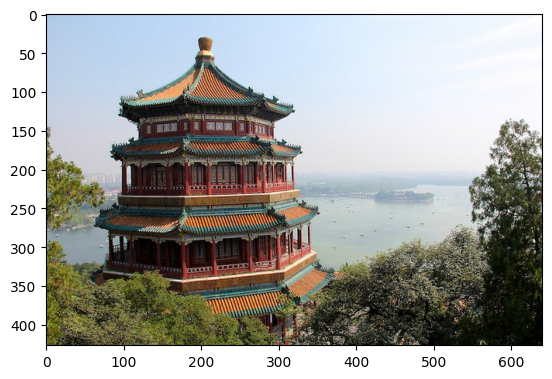

In [ ]:
#imagem original
plt.imshow(img)

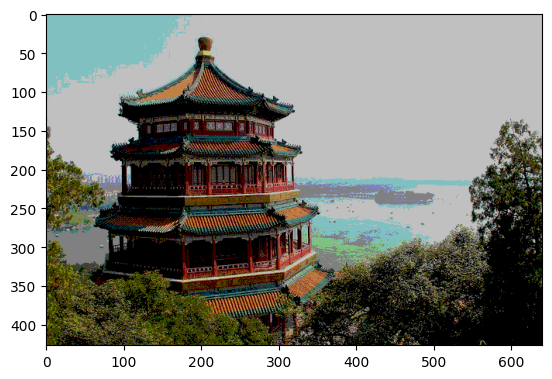

In [ ]:
#imagem quantizada pela função original
n_colors=64

ids1,dict_ids1=uniform_quant(img,n_colors)
im_quant1 = MyImgFormat(ids1,dict_ids1)
plt.imshow(im_quant1.unpack())

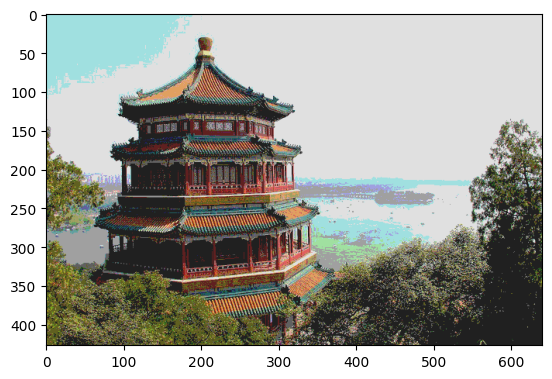

In [ ]:
#imagem quantizada pela função alterada
n_colors=64

ids2,dict_ids2=uniform_quant_meio(img,n_colors)
im_quant2 = MyImgFormat(ids2,dict_ids2)
plt.imshow(im_quant2.unpack())

c) Comparar tamanho em KB das 3 imagens da questão anterior. (Dica: use a
função get_bin_size_kb)

In [ ]:
print('original:', get_bin_size_kb(img),'\nquantizada_original:', get_bin_size_kb(im_quant1),'\nquantizada_alterada:', get_bin_size_kb(im_quant2))

original: 820.005 
quantizada_original: 206.207 
quantizada_alterada: 206.207


#Exercício 2

a) Implementar uma estratégia de quantização de imagens usando o K-Means
para determinar os valores RGB de cada um dos IDs das cores. Modifique os
valores dos parâmetros do construtor da classe K-Means como achar
necessário, mas deixe os parâmetros listados abaixo com os valores
indicados para que seja fácil reproduzir seus resultados:

○ max_iter=10,


○ random_state=42

In [ ]:
from sklearn.cluster import KMeans

def kmeans_quant(im, n_colors):

    #transformando a imagem em uma matriz 2d em que as linhas possuem o rgb de cada pixel
    X = im.reshape((-1, 3))

    #criando objeto kmeans
    kmeans = KMeans(n_clusters=n_colors, max_iter=10, random_state=42)
    kmeans.fit(X)

    #gerando matriz de ids e seu dicionário
    mat_ids = np.uint8(kmeans.predict(X).reshape((im.shape[0],im.shape[1])))
    pixel_vals = np.uint8(kmeans.cluster_centers_)
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}

    return mat_ids, dict_id2pixel

b) Rode o método usando o K-Means para quantizar a imagem 'china.jpg' para
64 cores e compare visualmente a imagem gerada com os resultados da
Questão 1. Comente os resultados.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


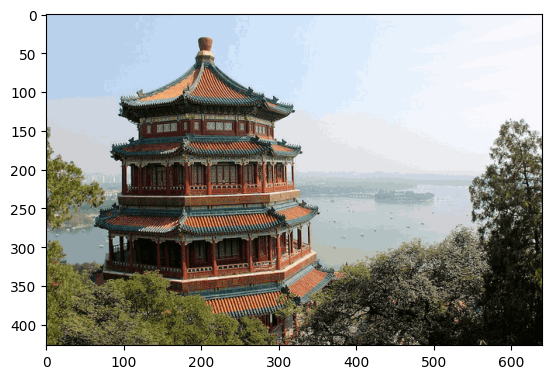

In [ ]:
n_colors=64

mat_ids_kmeans, dict_id2pixel_kmeans = kmeans_quant(img, n_colors)
im_quant_kmeans = MyImgFormat(mat_ids_kmeans, dict_id2pixel_kmeans)
plt.imshow(im_quant_kmeans.unpack())

Por inspeção visual, é possível afirmar que o resultado obtido por kmeans é superior, devido à maior suavidade nas transições de cores observadas na contrução, mar, céu e árvores. Isso provavelmente decorre do fato de todas as cores utilizadas pelo kmeans serem próximas das cores da imagem original, enquanto que, nos outros métodos de quantização, as cores representam todo o espaço rgb, ao invés da parcela que está contida na imagem original. Assim, por dividir todo o espaço de cores rgb pelo valor dado, não necessiariamente as cores admitidas serão utilizadas pela imagem, fazendo com que a variedade de cores na imagem final seja menor que o desejado.

# Exercício 3

a) Existem diversas maneiras de se estimar a quantidade "ótima" de clusters
para um algoritmos como K-Means. Uma delas é uma análise baseada na
medida de inércia. Implemente o cálculo da
inércia dentro da função de quantização baseada no K-Means.

In [ ]:
#quantização por kmeans que retorna a soma dos erros quadráticos

def kmeans_quant_inertia(im, n_colors):

   #transformando a imagem em uma matriz 2d em que as linhas possuem o rgb de cada pixel
    X = im.reshape((-1, 3))

    #criando objeto kmeans
    kmeans = KMeans(n_clusters=n_colors, max_iter=10, random_state=42)
    kmeans.fit(X)

    #gerando matriz de ids e seu dicionário
    mat_ids = np.uint8(kmeans.predict(X).reshape((im.shape[0],im.shape[1])))
    pixel_vals = np.uint8(kmeans.cluster_centers_)
    dict_id2pixel = {i: list(pixel_vals[i]) for i in range(len(pixel_vals))}

    return mat_ids, dict_id2pixel, kmeans.inertia_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

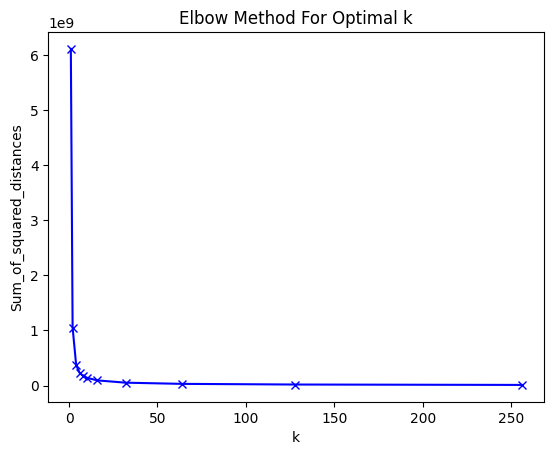

In [ ]:
img = load_sample_image('china.jpg')

#valores escolhidos com base em inércias plotadas de teste, visando reduzir o tempo de processamento com menos valores de 'k'
index = [1,2,4,6,8,10,16,32,64,128,256]
inertia=[]

#quantizando para os valores de cores em index
for k in index:
      mat_ids, dict_id2pixel, temp_inertia = kmeans_quant_inertia(img, k)
      inertia.append(temp_inertia)

#plotando a inércia
plt.plot(index, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

b) Implemente uma função de comparação que calcula o MSE entre os pixels
da imagem original e os da imagem quantizada.

In [ ]:
from skimage.metrics import mean_squared_error as mse

In [ ]:
img_orig=img #original
img_quant1=im_quant1.unpack() #quantização uniforme original
img_quant2=im_quant2.unpack() #quantização uniforme alterada
img_quant3=im_quant_kmeans.unpack() #quantização kmeans

print('MSE para quantização uniforme original: ', mse(img_orig,img_quant1),'\nMSE para quantização uniforme modificada: ', mse(img_orig,img_quant2),'\nMSE para quantização kmeans: ', mse(img_orig,img_quant3), '\n\nobs: todas quantizadas para 64 cores')

MSE para quantização uniforme original:  1506.2420277127244 
MSE para quantização uniforme modificada:  364.19159836065575 
MSE para quantização kmeans:  38.110081235363 

obs: todas quantizadas para 64 cores


#Exercício 4

a) Faça a quantização das imagens para {8, 27, 64, 125, 216} cores usando
ambos os métodos de quantização (uniforme e K-Means)

In [ ]:
n_cores = [8,27,64,125,216]
img1 = load_sample_image('china.jpg')
img2 = load_sample_image('flower.jpg')

#armazena a quantização para os métodos
mat_ids_kmean1=[]; dict_ids_kmeans1=[]; inert1=[];
mat_ids_kmean2=[]; dict_ids_kmeans2=[]; inert2=[];
mat_ids_unif1=[]; dict_ids_unif1=[]
mat_ids_unif2=[]; dict_ids_unif2=[]

#gerando as quantizações
for i in n_cores:
  #kmeans china.jgp
  mat_id_kmean1, dict_id_kmean1, inertia1 = kmeans_quant_inertia(img1, i);
  mat_ids_kmean1.append(mat_id_kmean1); dict_ids_kmeans1.append(dict_id_kmean1); inert1.append(inertia1)
  #kmeans flower.jgp
  mat_id_kmean2, dict_id_kmean2, inertia2 = kmeans_quant_inertia(img2, i);
  mat_ids_kmean2.append(mat_id_kmean2); dict_ids_kmeans2.append(dict_id_kmean2); inert2.append(inertia2)
  #unif china.jgp
  mat_id_unif1, dict_id_unif1 = uniform_quant(img1, i);
  mat_ids_unif1.append(mat_id_unif1); dict_ids_unif1.append(dict_id_unif1)
  #unif flower.jgp
  mat_id_unif2, dict_id_unif2 = uniform_quant(img2, i);
  mat_ids_unif2.append(mat_id_unif2); dict_ids_unif2.append(dict_id_unif2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [ ]:
#salvando as imagens geradas com MyImgFormat

img_kmean1=[];img_kmean2=[];img_unif1=[];img_unif2=[]

for i in range(len(n_cores)):
  img_kmean1.append(MyImgFormat(mat_ids_kmean1[i],dict_ids_kmeans1[i]))
  img_kmean2.append(MyImgFormat(mat_ids_kmean2[i],dict_ids_kmeans2[i]))
  img_unif1.append(MyImgFormat(mat_ids_unif1[i],dict_ids_unif1[i]))
  img_unif2.append(MyImgFormat(mat_ids_unif2[i],dict_ids_unif2[i]))

b) Compute e faça um plot da inércia dos resultados das quantizações do
K-Means obtidas no item a)

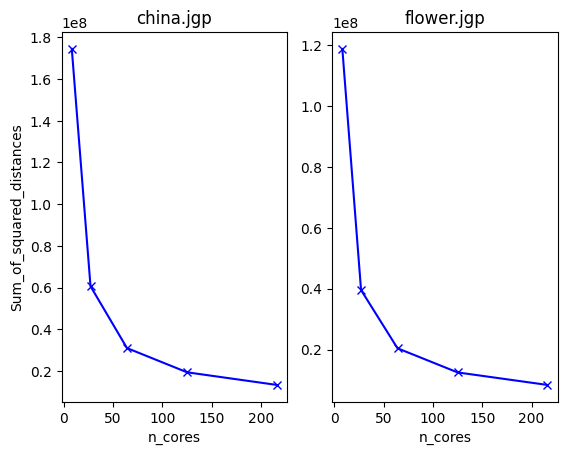

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(n_cores, inert1, 'bx-')
plt.xlabel('n_cores')
plt.ylabel('Sum_of_squared_distances')
plt.title('china.jgp')

plt.subplot(1, 2, 2)
plt.plot(n_cores, inert2, 'bx-')
plt.xlabel('n_cores')
plt.title('flower.jgp')

plt.show()

c) Compute e faça um plot dos MSEs de ambas as estratégias. Qual das
estratégias teve um melhor MSE? Isso faz sentido quando fazemos uma
comparação visual dos resultados?


<ipython-input-23-5b443112dddc>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(n_cores, y_kmean1, 'bx-', label='kmean', color='r')
<ipython-input-23-5b443112dddc>:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(n_cores, y_kmean2, 'bx-', label='kmean', color='r')


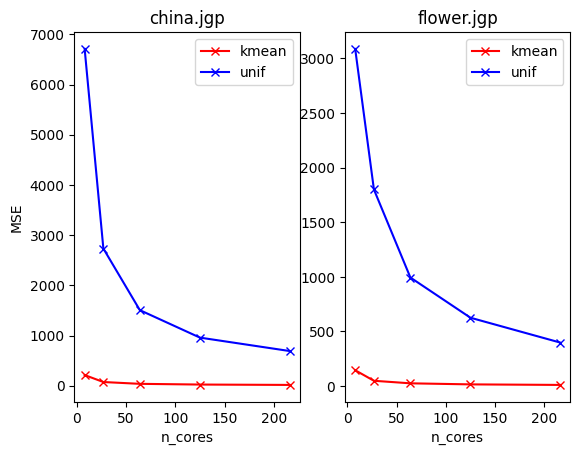

In [ ]:
y_kmean1=[]; y_kmean2=[]; y_unif1=[]; y_unif2=[]

# gerando o mse para as duas imagens por cada método variando o n_cores
for i in range(len(n_cores)):
  y_kmean1.append( mse( img1, img_kmean1[i].unpack() ) )
  y_kmean2.append( mse( img2, img_kmean2[i].unpack() ) )
  y_unif1.append( mse( img1, img_unif1[i].unpack() ) )
  y_unif2.append( mse( img2, img_unif2[i].unpack() ) )

#plotando
plt.subplot(1, 2, 1)
plt.plot(n_cores, y_kmean1, 'bx-', label='kmean', color='r')
plt.plot(n_cores, y_unif1, 'bx-', label='unif')
plt.xlabel('n_cores')
plt.ylabel('MSE')
plt.legend()
plt.title('china.jgp')

plt.subplot(1, 2, 2)
plt.plot(n_cores, y_kmean2, 'bx-', label='kmean', color='r')
plt.plot(n_cores, y_unif2, 'bx-', label='unif')
plt.xlabel('n_cores')
plt.legend()
plt.title('flower.jgp')

plt.show()

Kmeans obteve um melhor MSE, o que está de acordo com o observado no exercício 2 b), onde foi constatado que a imagem quantizada por kmeans aparenta estar muito mais próxima à imagem original.

d) Compute e faça um plot do tamanho e KBs das imagens quantizadas e
compare com o tamanho em KBs da imagem original. Faça a comparação
considerando os seguintes pontos:

○ Use a função get_bin_size_kb para calcular os tamanhos das imagens
em KBs;

○ Para a imagem original, calcule o tamanho do numpy.ndarray que
contém os pixels RGB da imagem;

○ Para as imagens quantizadas, compute o tamanho do objeto
MyImageFormat criado usando os resultados da quantização.

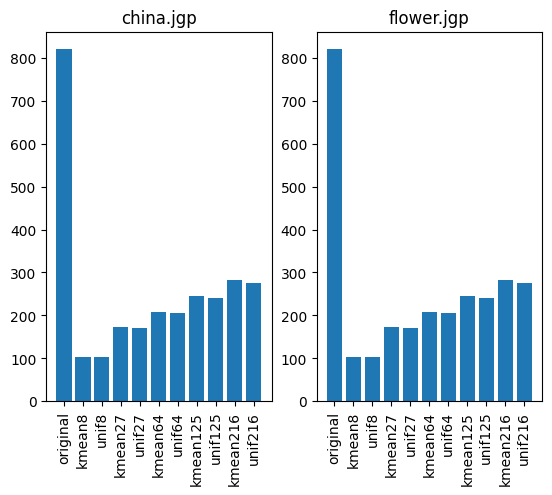

In [ ]:
y1=[]; y2=[]; x=[]

#peso das imagens originais
y1.append(get_bin_size_kb(img1))
y2.append(get_bin_size_kb(img2))
x.append('original')

#peso de cada imagem quantizada (objeto MyImgFormat)
for i in range(len(n_cores)):
  y1.append(get_bin_size_kb(img_kmean1[i]))
  y2.append(get_bin_size_kb(img_kmean2[i]))
  y1.append(get_bin_size_kb(img_unif1[i]))
  y2.append(get_bin_size_kb(img_unif2[i]))
  x.append('kmean'+str(n_cores[i]))
  x.append('unif'+str(n_cores[i]))

#plotando
plt.subplot(1, 2, 1)
plt.bar(x,y1,align='center')
plt.xticks(rotation='vertical')
plt.title('china.jgp')

plt.subplot(1, 2, 2)
plt.bar(x,y2,align='center')
plt.xticks(rotation='vertical')
plt.title('flower.jgp')

plt.show()

In [ ]:
#valores
for i in range(len(x)):
  print('peso kb',x[i], ": china.jpg","=", y1[i], "; flower.jpg ","=", y2[i],"\n")

peso kb original : china.jpg = 820.005 ; flower.jpg  = 820.005 

peso kb kmean8 : china.jpg = 103.191 ; flower.jpg  = 103.189 

peso kb unif8 : china.jpg = 103.003 ; flower.jpg  = 103.003 

peso kb kmean27 : china.jpg = 172.288 ; flower.jpg  = 172.282 

peso kb unif27 : china.jpg = 171.577 ; flower.jpg  = 171.577 

peso kb kmean64 : china.jpg = 207.971 ; flower.jpg  = 207.921 

peso kb unif64 : china.jpg = 206.207 ; flower.jpg  = 206.207 

peso kb kmean125 : china.jpg = 244.666 ; flower.jpg  = 244.6 

peso kb unif125 : china.jpg = 241.125 ; flower.jpg  = 241.125 

peso kb kmean216 : china.jpg = 282.735 ; flower.jpg  = 282.512 

peso kb unif216 : china.jpg = 276.406 ; flower.jpg  = 276.406 

